In [1]:
import shapely                 #needed to set geopandas geometry 
from shapely.wkt import loads  #needed to set geopandas geometry
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from pysal.model import mgwr
import pysal.lib
import libpysal as ps
from libpysal.weights.contiguity import Queen
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# conda install mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
#warnings.filterwarnings("ignore")

In [2]:
pip install matplotlib_scalebar

Note: you may need to restart the kernel to use updated packages.


In [3]:
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
df = pd.read_csv("C:/Users/samue/OneDrive - King's College London/Desktop/KCL Y3/Dissertation/1 Datasets/Python/Master (LSOA).csv", encoding= "unicode_escape") 

In [5]:
df.columns

Index(['LSOA Code', 'LSOA Name', 'LAD Code (2021 boundaries)',
       'LAD name (2021 boundaries)', 'geometry', 'X', 'Y', 'Pop', '<16', '>65',
       'POPDEN (km2)', 'AREA (m^2)', 'EthWhite', 'EthMixed', 'EthAsian',
       'EthBlack', 'UnE', 'LTHP', 'LTHP Prop', 'PoorHealth', 'PoorHealth Prop',
       'IncDeprived', 'MedianInc', 'MedianHousePrice', 'Aldi', 'ASDA',
       'Iceland', 'Lidl', 'Tesco', 'Sainsburys', 'Morrisons',
       'Marks and Spencer', 'The Co-operative Group', 'Waitrose', 'Total SM',
       'Greengrocer', 'ASDA_Delivery', 'Ice_Delivery', 'Sain_Delivery',
       'Mor_Delivery', 'Tesc_Delivery', 'Amaz_Delivery', 'Wait_Delivery',
       'Ocad_Delivery', 'Total Del', 'proximity', 'nearest budget',
       'nearest mid', 'nearest premium', 'variety', 'density'],
      dtype='object')

In [6]:
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf['geometry'] = gdf['geometry'].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry('geometry')

In [7]:
gdf["density"] = pd.to_numeric(gdf["density"])

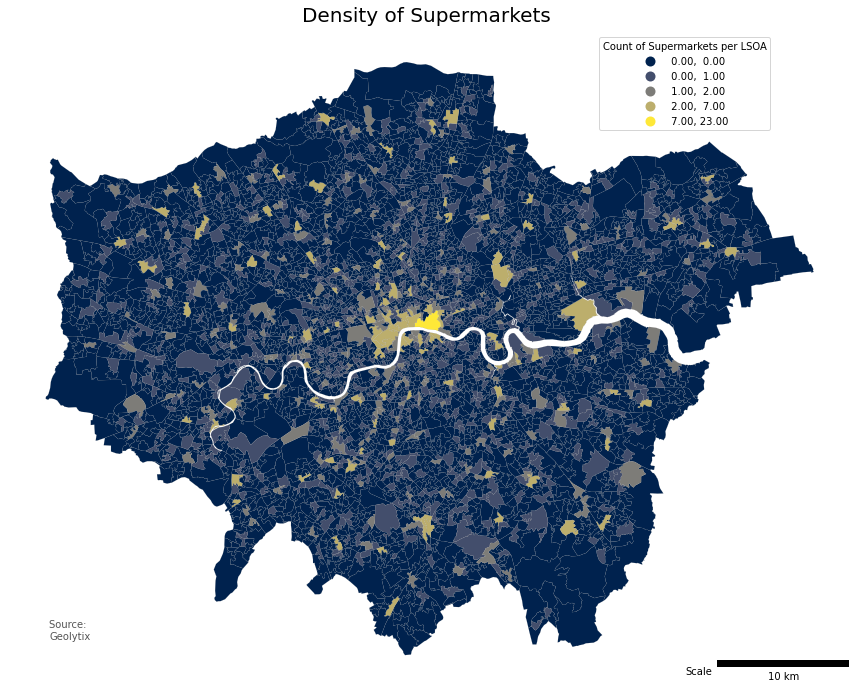

In [30]:
fig, ax1 = plt.subplots(1, figsize=(18, 12))  
gdf.plot(column='density', ax=ax1, 
         scheme='fisherjenks', k=5, cmap='cividis',
         edgecolor='grey', linewidth=0.1,        #change line style
         legend=True, 
         legend_kwds={'title': "Count of Supermarkets per LSOA",'loc': (0.70,0.85)} #legend settings
        ) 


#titles
plt.suptitle('Density of Supermarkets', size=20, x=0.51, y=0.91) 

#add source info on the image itself
ax1.annotate('Source: \nGeolytix',
             xy=(0.05, 0.1), xycoords='axes fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=10, color='#555555')  

ax1.set_axis_off()

scale1 = ScaleBar(
dx=1, label='Scale',
    location='lower right',  # in relation to the whole plot
    label_loc='left', scale_loc='bottom'  # in relation to the line
)

ax1.add_artist(scale1)

plt.savefig('FINAL_Density by LSOA.png', dpi=1800)

In [9]:
#correlation matrix

In [10]:
df_data = df[['density', 'EthWhite','EthMixed','EthAsian','EthBlack','UnE','LTHP Prop', 'PoorHealth Prop','MedianInc','MedianHousePrice']]

In [11]:
# Create a correlation matrix here using pandas
corr= df_data.corr()

In [12]:
# style it
corr.style.background_gradient(cmap='coolwarm')

,density,EthWhite,EthMixed,EthAsian,EthBlack,UnE,LTHP Prop,PoorHealth Prop,MedianInc,MedianHousePrice
density,1.000000,0.020454,0.035975,-0.004320,-0.010170,-0.045909,-0.197099,-0.131839,0.053960,0.013391
EthWhite,0.020454,1.000000,-0.283053,-0.588907,-0.757297,-0.621411,-0.119016,-0.343364,0.593798,0.316799
EthMixed,0.035975,-0.283053,1.000000,0.595240,-0.232808,0.402182,-0.015583,0.213826,-0.231593,-0.093470
EthAsian,-0.004320,-0.588907,0.595240,1.000000,-0.033634,0.703877,0.176839,0.389649,-0.590722,-0.364630
EthBlack,-0.010170,-0.757297,-0.232808,-0.033634,1.000000,0.187151,-0.004631,0.070209,-0.277477,-0.156410
UnE,-0.045909,-0.621411,0.402182,0.703877,0.187151,1.000000,0.401274,0.642482,-0.750730,-0.410233
LTHP Prop,-0.197099,-0.119016,-0.015583,0.176839,-0.004631,0.401274,1.000000,0.847494,-0.494035,-0.302445
PoorHealth Prop,-0.131839,-0.343364,0.213826,0.389649,0.070209,0.642482,0.847494,1.000000,-0.612795,-0.308545
MedianInc,0.053960,0.593798,-0.231593,-0.590722,-0.277477,-0.750730,-0.494035,-0.612795,1.000000,0.759300
MedianHousePrice,0.013391,0.316799,-0.093470,-0.364630,-0.156410,-0.410233,-0.302445,-0.308545,0.759300,1.000000


In [13]:
from spglm.family import Gaussian, Binomial, Poisson

In [14]:
x = ['EthWhite', 'EthMixed', 'EthAsian','EthBlack', 'UnE', 'LTHP Prop', 'PoorHealth Prop', 'MedianInc', 'MedianHousePrice'] # define input/independant variables
X = df.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(df['density']) # define output/dependant variable

# Note the difference in argument order
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
#model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4835
Model:                            GLM   Df Residuals:                     4825
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3714.1
Date:                Tue, 07 Mar 2023   Deviance:                       4856.8
Time:                        14:37:15   Pearson chi2:                 7.46e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1451      0.811  

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
df['logEthWhite'] = np.log(df['EthWhite'])
df['logEthMixed'] = np.log(df['EthMixed'])
df['logEthBlack'] = np.log(df['EthBlack'])
df['logLTHP'] = np.log(df['LTHP Prop']) 
df['logPoorHealth'] = np.log(df['PoorHealth Prop']) 
df['logMedianInc'] = np.log(df['MedianInc'])
df['logMedianHousePrice'] = np.log(df['MedianHousePrice'])

In [17]:
x = ['logEthWhite', 'logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logPoorHealth', 'logMedianInc', 'logMedianHousePrice'] # define input/independant variables
X = df.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(df['density']) # define output/dependant variable

# Note the difference in argument order
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4835
Model:                            GLM   Df Residuals:                     4825
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3716.3
Date:                Tue, 07 Mar 2023   Deviance:                       4861.2
Time:                        14:39:56   Pearson chi2:                 7.10e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.7508    

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
#suppress scientific notation
import numpy as np
np.set_printoptions(suppress=True)

#create instance of influence
influence = model.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance

#display Cook's distances
cooks

(array([0.00483552, 0.000162  , 0.00009187, ..., 0.00007421, 0.00048167,
        0.0000131 ]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [19]:
OLSsummary = influence.summary_frame()
OLSsummary

,dfb_const,dfb_logEthWhite,dfb_logEthMixed,dfb_EthAsian,dfb_logEthBlack,dfb_UnE,dfb_logLTHP,dfb_logPoorHealth,dfb_logMedianInc,dfb_logMedianHousePrice,cooks_d,standard_resid,hat_diag,dffits_internal
0,-0.180047,-0.008792,0.011077,0.011645,0.022416,0.099513,0.107066,-0.083339,0.175440,-0.100156,0.004836,3.222086,0.004636,0.219898
1,0.034277,0.006162,-0.000025,-0.001811,0.001896,-0.006573,-0.001638,-0.004678,-0.035492,0.022895,0.000162,-0.605150,0.004404,-0.040249
2,0.024834,-0.002291,-0.001154,-0.001604,-0.007164,-0.008104,-0.001302,-0.005808,-0.027517,0.019844,0.000092,-0.547976,0.003050,-0.030311
3,-0.175841,-0.006785,0.056236,-0.056323,0.050368,0.129485,-0.012847,0.036808,0.193696,-0.140055,0.005611,3.462678,0.004658,0.236874
4,0.014216,0.008426,0.005887,0.006041,-0.003562,-0.011877,-0.001654,0.000773,-0.014117,0.009944,0.000076,-0.610581,0.002047,-0.027657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,0.035593,0.006528,0.008325,-0.002446,0.010350,-0.029788,0.040439,-0.026543,-0.040412,0.042115,0.000714,-1.032423,0.006658,-0.084527
4831,-0.022669,-0.005118,-0.025239,0.050646,-0.003921,-0.010657,-0.003109,0.001219,0.016923,-0.003034,0.000481,0.566077,0.014796,0.069373
4832,0.012890,-0.009022,0.011838,-0.017548,-0.008945,-0.004785,0.003762,-0.007402,-0.013752,0.010235,0.000074,-0.568150,0.002294,-0.027241
4833,0.024872,0.005783,0.028620,-0.044088,0.009006,0.011507,0.014047,-0.012617,-0.024287,0.019591,0.000482,-0.759299,0.008285,-0.069403


In [20]:
#identifying rows of data with outliers/cook's distance > 4/n
thres = 4/4835 #4/n
influentialdata = OLSsummary["cooks_d"] > thres
np.where(influentialdata)[0]

array([   0,    3,    8,   11,   90,   91,  137,  142,  157,  165,  176,
        188,  245,  252,  259,  302,  309,  328,  351,  357,  387,  389,
        397,  408,  425,  451,  456,  462,  477,  502,  516,  564,  575,
        577,  578,  580,  616,  621,  641,  643,  660,  661,  688,  699,
        713,  741,  770,  774,  791,  797,  817,  832,  835,  836,  845,
        880,  896,  898,  903,  909,  910,  912,  927,  935,  951,  994,
       1004, 1024, 1026, 1029, 1046, 1057, 1078, 1106, 1117, 1157, 1164,
       1172, 1202, 1206, 1228, 1230, 1241, 1246, 1303, 1308, 1341, 1347,
       1385, 1394, 1408, 1428, 1490, 1496, 1535, 1585, 1589, 1590, 1608,
       1629, 1632, 1640, 1653, 1712, 1720, 1735, 1784, 1809, 1810, 1813,
       1844, 1852, 1885, 1895, 1900, 1942, 1957, 1973, 1980, 1982, 2018,
       2019, 2027, 2079, 2080, 2092, 2100, 2139, 2158, 2175, 2192, 2210,
       2231, 2234, 2242, 2274, 2282, 2305, 2309, 2315, 2334, 2335, 2345,
       2355, 2380, 2420, 2445, 2478, 2527, 2535, 25

In [23]:
df.drop([ 0, 3, 8, 11, 90, 91, 137, 142, 157, 165, 176, 188,  245,  252,  259,  302,  309,  328,  351,  357,  387,  389, 397,  408,  425,  451,  456,  462,  477,  502,  516,  564,  575, 577,  578,  580,  616,  621,  641,  643,  660,  661,  688,  699, 713,  741,  770,  774,  791,  797,  817,  832,  835,  836,  845, 880,  896,  898,  903,  909,  910,  912,  927,  935,  951,  994, 1004, 1024, 1026, 1029, 1046, 1057, 1078, 1106, 1117, 1157, 1164, 1172, 1202, 1206, 1228, 1230, 1241, 1246, 1303, 1308, 1341, 1347, 1385, 1394, 1408, 1428, 1490, 1496, 1535, 1585, 1589, 1590, 1608,1629, 1632, 1640, 1653, 1712, 1720, 1735, 1784, 1809, 1810, 1813, 1844, 1852, 1885, 1895, 1900, 1942, 1957, 1973, 1980, 1982, 2018, 2019, 2027, 2079, 2080, 2092, 2100, 2139, 2158, 2175, 2192, 2210, 2231, 2234, 2242, 2274, 2282, 2305, 2309, 2315, 2334, 2335, 2345, 2355, 2380, 2420, 2445, 2478, 2527, 2535, 2540, 2560, 2573, 2577, 2579, 2602, 2605, 2632, 2634, 2635, 2643, 2658, 2669, 2705, 2732, 2740, 2755, 2770, 2805, 2811, 2813, 2818, 2838, 2846, 2860, 2902, 2921, 2937, 2946, 2950, 2953, 2956, 2959, 2963, 2970, 2972, 2980, 3006, 3012, 3050, 3058, 3060, 3098, 3125, 3223, 3244, 3246, 3253, 3293, 3296, 3305, 3372, 3379, 3382, 3408, 3412, 3443, 3444, 3448, 3479, 3486, 3492, 3532, 3536, 3563, 3584, 3591, 3605, 3606, 3620, 3682, 3683, 3684, 3693, 3698, 3722, 3768, 3783, 3790, 3810, 3823,3835, 3836, 3838, 3841, 3846, 3848, 3853, 3889, 3891, 3900, 3910, 3929, 3961, 3964, 3969, 4004, 4020, 4043, 4079, 4089, 4106, 4109, 4114, 4124, 4135, 4144, 4151, 4158, 4169, 4172, 4175, 4179, 4186, 4188, 4196, 4199, 4201, 4210, 4245, 4288, 4298, 4311, 4321, 4363,4370, 4396, 4414, 4440, 4441, 4461, 4475, 4487, 4495, 4498, 4543, 4568, 4569, 4570, 4579, 4591, 4593, 4610, 4613, 4614, 4615, 4628, 4629, 4638, 4640, 4641, 4662, 4666, 4669, 4672, 4674, 4675, 4676, 4683, 4684, 4686, 4687, 4689, 4691, 4692, 4694, 4695, 4696, 4697, 4701, 4714, 4736, 4739, 4741, 4753, 4755, 4761, 4762, 4764, 4765, 4769, 4776, 4781, 4782, 4785, 4812, 4814, 4816, 4818, 4821, 4823, 4824], axis=0, inplace=True)

In [25]:
x = ['logEthWhite', 'logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logPoorHealth', 'logMedianInc', 'logMedianHousePrice'] # define input/independant variables
X = df.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(df['density']) # define output/dependant variable

# Note the difference in argument order
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4493
Model:                            GLM   Df Residuals:                     4483
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2289.4
Date:                Tue, 07 Mar 2023   Deviance:                       2851.7
Time:                        14:43:37   Pearson chi2:                 4.00e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  15.2489    

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#After Variable Selection/Removal of high VIF values in R

In [26]:
df_final = df[['LSOA Code','LSOA Name','geometry', 'X', 'Y', 'Pop', 'logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logMedianInc','Aldi','ASDA','Iceland','Lidl','Tesco','Sainsburys','Morrisons','Marks and Spencer','The Co-operative Group','Waitrose','Total SM','ASDA_Delivery','Ice_Delivery','Sain_Delivery','Mor_Delivery','Tesc_Delivery','Amaz_Delivery', 'Wait_Delivery','Ocad_Delivery','Total Del', 'density']]

In [27]:
df_final.to_csv('densitydfarcgis.csv')

In [28]:
x = ['logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logMedianInc'] # define input/independant variables
X = df_final.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(df_final['density']) # define output/dependant variable

# Note the difference in argument order
model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4493
Model:                            GLM   Df Residuals:                     4486
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2324.9
Date:                Tue, 07 Mar 2023   Deviance:                       2922.8
Time:                        14:45:35   Pearson chi2:                 4.10e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.0939      3.709      4.069   

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
X = df_final[['logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logMedianInc']]   # independent variables
y = df_final['density']   # dependent variables
X = sm.add_constant(X)
# fit the regression model
reg = sm.OLS(y, X).fit()
# get Variance Inflation Factor (VIF) 
pd.DataFrame({'variables':X.columns[1:], 'VIF':[variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]})

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,variables,VIF
0,logEthMixed,1.577348
1,EthAsian,2.833964
2,logEthBlack,1.184061
3,UnE,3.556065
4,logLTHP,1.483691
5,logMedianInc,3.600454


In [31]:
#GWR

In [51]:
df_final = df

In [52]:
df_final.to_csv(r'GWR_Dens.csv', index=False)

## End here

In [33]:
#Prepare dataset inputs
g_y = df_final['density'].values.reshape((-1,1))
g_X = df_final[['logEthMixed', 'EthBlack', 'logLTHP', 'logMedianHousePrice']].values
u = df_final['X']
v = df_final['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
#g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
#g_y = g_y.reshape((-1,1))
#g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [34]:
bw=mgwr.sel_bw.Sel_BW(g_coords,g_y,g_X,family=Poisson(), offset=None,constant=False)
bw=bw.search()
bw

2419.0

In [35]:
gwr_model=GWR(g_coords,g_y,g_X,bw,family=Poisson(),offset=None,constant=False).fit()

In [36]:
gwr_model.summary()

Model type                                                          Poisson
Number of observations:                                                4493
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          2941.928
Log-likelihood:                                                   -2333.374
AIC:                                                               4678.748
AICc:                                                              2951.686
BIC:                                                             -34794.980
Percent deviance explained:                                           0.068
Adj. percent deviance explained:                                      0.067

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [37]:
#visualising GWR model

In [38]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = gwr_model.filter_tvals(alpha=.05)
filtered_estimates

array([[ 2.77023544,  0.        ,  3.08982305,  0.        , -8.7125946 ,
         0.        ],
       [ 2.86466304,  0.        ,  3.21930106,  0.        , -8.70629866,
         0.        ],
       [ 2.12859929,  0.        , -2.29637827,  0.        , -8.02849958,
        -4.53950761],
       ...,
       [ 2.17718337,  0.        , -2.2666194 ,  0.        , -7.74633967,
        -4.42299915],
       [ 2.3544908 ,  0.        , -2.21020125,  0.        , -7.39993976,
        -4.1586497 ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -9.39637204,
        -4.65627737]])

In [39]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)

In [40]:
data_params

,0,1,2,3,4,5
0,2.770235,0.0,3.089823,0.0,-8.712595,0.000000
1,2.864663,0.0,3.219301,0.0,-8.706299,0.000000
2,2.128599,0.0,-2.296378,0.0,-8.028500,-4.539508
3,2.016820,0.0,-2.322528,0.0,-8.290946,-4.708415
4,0.000000,0.0,-2.335192,0.0,-8.482320,-4.821101
...,...,...,...,...,...,...
4488,2.170975,0.0,-2.280393,0.0,-7.762142,-4.434652
4489,2.296488,0.0,-2.246611,0.0,-7.568063,-4.274678
4490,2.177183,0.0,-2.266619,0.0,-7.746340,-4.422999
4491,2.354491,0.0,-2.210201,0.0,-7.399940,-4.158650


In [41]:
# Create the new dataframe 'logEthMixed', 'EthAsian','logEthBlack', 'UnE', 'logLTHP', 'logMedianInc'
df1=pd.DataFrame(df_final["LSOA Code"])
df2 = df1.assign(logEthMixed=data_params[0],
                 EthAsian=data_params[1],
                 logEthBlack=data_params[2],
                 UnE=data_params[3],
                 logLTHP=data_params[4],
                 logMedianInc=data_params[5])
df2.columns
df2

,LSOA Code,logEthMixed,EthAsian,logEthBlack,UnE,logLTHP,logMedianInc
1,E01000002,2.864663,0.0,3.219301,0.0,-8.706299,0.000000
2,E01000003,2.128599,0.0,-2.296378,0.0,-8.028500,-4.539508
4,E01000006,0.000000,0.0,-2.335192,0.0,-8.482320,-4.821101
5,E01000007,2.075754,0.0,-2.308039,0.0,-8.171601,-4.630426
6,E01000008,2.044015,0.0,-2.309098,0.0,-8.248736,-4.674369
...,...,...,...,...,...,...,...
4830,E01033742,NaN,NaN,NaN,NaN,NaN,NaN
4831,E01033743,NaN,NaN,NaN,NaN,NaN,NaN
4832,E01033744,NaN,NaN,NaN,NaN,NaN,NaN
4833,E01033745,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#read shapefile of UK
LSOA_shp=gpd.read_file('Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Super_Generalised_Clipped_(BSC)_EW_V3.shp')
LSOA_shp.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,157794.481079,1685.391778,"POLYGON ((532282.629 181906.496, 532248.250 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,"POLYGON ((532746.814 181786.892, 532248.250 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,"POLYGON ((532293.068 182068.422, 532419.592 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,212682.404259,2028.654904,"POLYGON ((533604.245 181418.129, 533743.689 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,"POLYGON ((545271.918 184183.948, 545296.314 18..."


In [43]:
# Let's check the CRS - we need projected CRS for calculating the spatial weight
LSOA_shp.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [44]:
# Merge our shapefile with the model's results
LSOA_shp = LSOA_shp.merge(df2, left_on='LSOA11CD', right_on='LSOA Code')
LSOA_shp.head()

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,LSOA Code,logEthMixed,EthAsian,logEthBlack,UnE,logLTHP,logMedianInc
0,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,164882.427628,1804.828196,"POLYGON ((532746.814 181786.892, 532248.250 18...",E01000002,2.864663,0.0,3.219301,0.0,-8.706299,0.000000
1,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,42219.805717,909.223277,"POLYGON ((532293.068 182068.422, 532419.592 18...",E01000003,2.128599,0.0,-2.296378,0.0,-8.028500,-4.539508
2,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,130551.387161,1716.896118,"POLYGON ((545271.918 184183.948, 545296.314 18...",E01000006,0.000000,0.0,-2.335192,0.0,-8.482320,-4.821101
3,6,E01000007,Barking and Dagenham 015A,Barking and Dagenham 015A,544189,184454,0.077792,51.54057,191313.039268,1811.549048,"POLYGON ((544348.715 184573.710, 544358.001 18...",E01000007,2.075754,0.0,-2.308039,0.0,-8.171601,-4.630426
4,7,E01000008,Barking and Dagenham 015B,Barking and Dagenham 015B,543576,184276,0.068886,51.53913,203647.039703,2850.028656,"POLYGON ((543619.802 184826.112, 543595.300 18...",E01000008,2.044015,0.0,-2.309098,0.0,-8.248736,-4.674369


In [45]:
#Download to shapefile here

SyntaxError: invalid syntax (Temp/ipykernel_21356/923163828.py, line 1)

In [46]:
LSOA_shp.to_csv(r'GWR_Dens.csv', index=False)

## End here

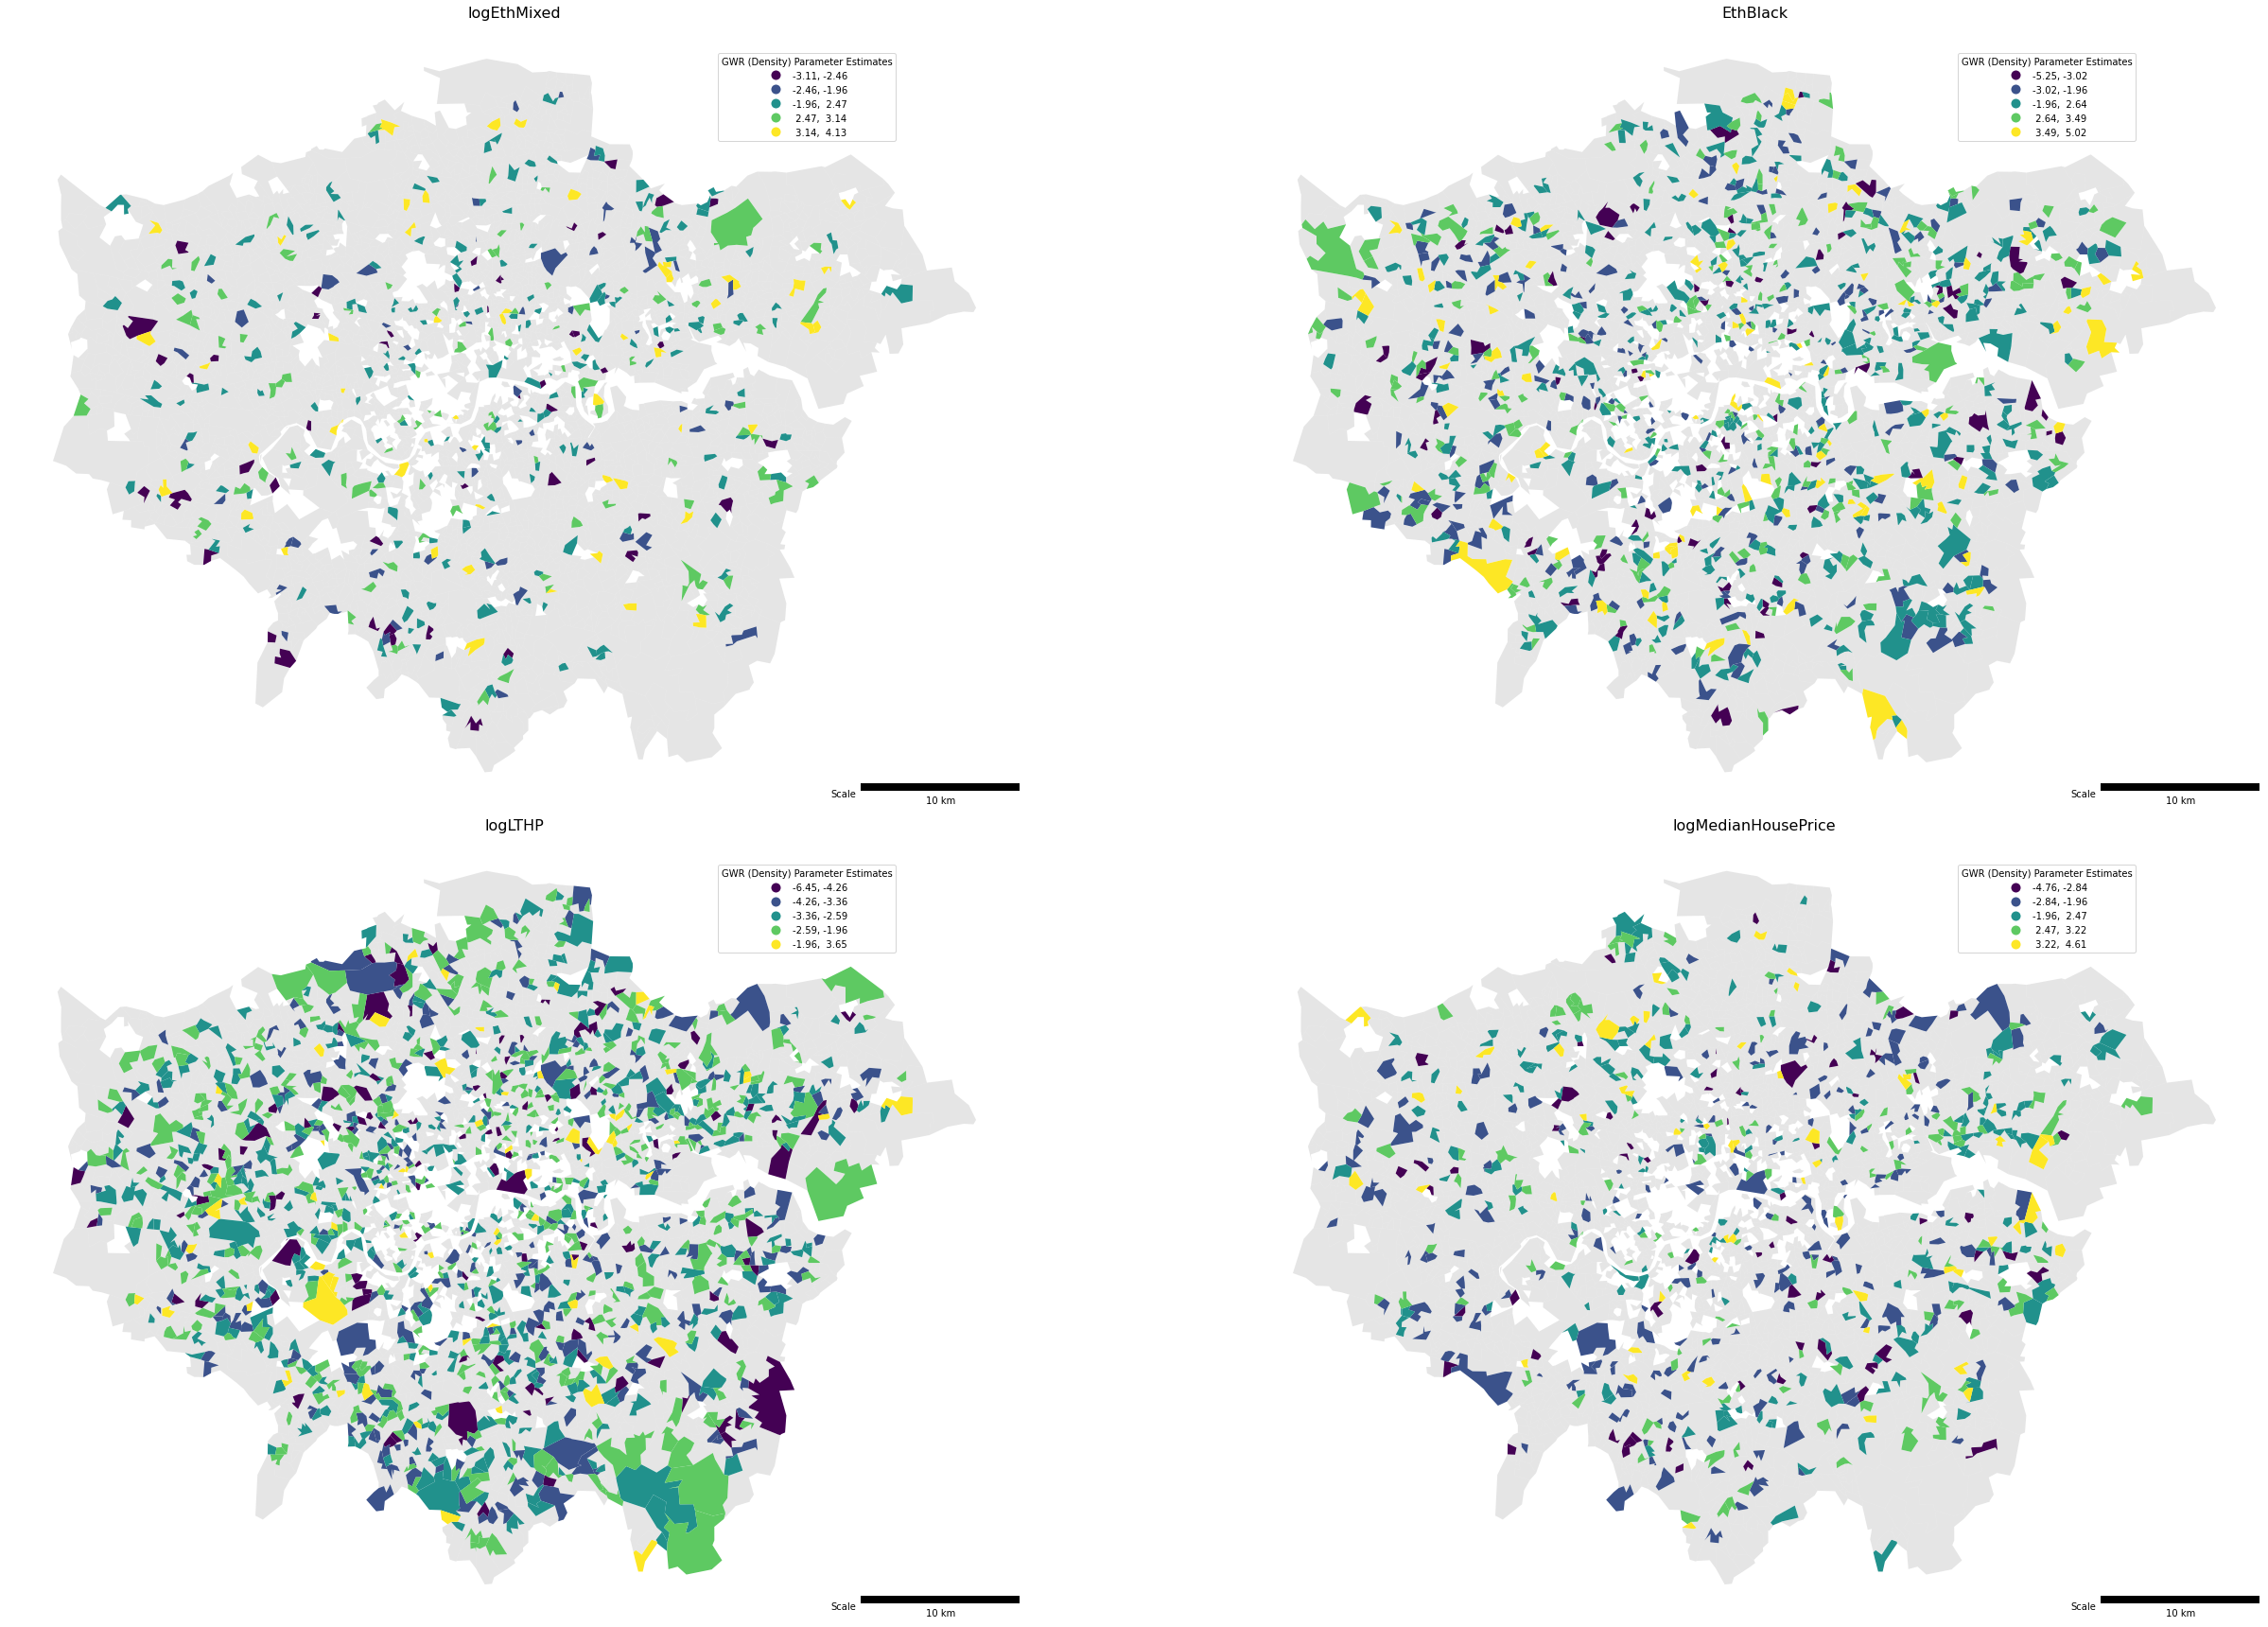

In [38]:
# First, let's create empty set of subplots with 2 rows and 2 columns
f,ax=plt.subplots(2,2,figsize=(40,24), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['logEthMixed', 'EthBlack', 'logLTHP', 'logMedianHousePrice']


# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    LSOA_temp = LSOA_shp.assign(toplot=filtered_estimates.T[i])
    ( LSOA_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    ( LSOA_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           scheme = 'FisherJenks', 
           k=5,
           legend=True,
           legend_kwds={'title': "GWR (Density) Parameter Estimates",'loc': (0.70,0.85)}))
    
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].set_axis_off()
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].add_artist(ScaleBar(1, label='Scale', location='lower right', label_loc='left', scale_loc='bottom'))


f.tight_layout()

plt.show()
#plt.savefig('GWR_Density.png', dpi=1600)
    

## CONTINUE HERE

In [ ]:
#MGWR

In [ ]:
#Prepare dataset inputs
g_y = df_final['density'].values.reshape((-1,1))
g_X = df_final[['logEthMixed', 'EthBlack', 'logLTHP', 'logMedianHousePrice']].values
u = df_final['X']
v = df_final['Y']
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
#g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
#g_y = g_y.reshape((-1,1))
#g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [69]:
np.isinf(g_coords).any()
np.isinf(g_y).any()
np.isinf(g_X).any()

False

In [70]:
np.isnan(g_coords).any()
np.isnan(g_y).any()
np.isnan(g_X).any()

False

In [68]:
selector=mgwr.sel_bw.Sel_BW(g_coords,g_y,g_X,multi=True,family=Poisson(),offset=None,constant=False)
selector.search(verbose=True)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\spglm\family.py:111: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
C:\Users\samue\anaconda3\envs\sds2021\lib\site-packages\spglm\iwls.py:35: RuntimeWarning: invalid value encountered in multiply
  xT = (x * wi).T


ValueError: array must not contain infs or NaNs

In [ ]:
mgwr_model=MGWR(coords,y,x,selector,family=Poisson(),offset=None,constant=False).fit()